## 測試Esun data 使用不同Classifier的預測結果

In [32]:
import glob
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
from  sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from  sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

from sklearn import preprocessing


random_state = 0

# 測試50個字

In [33]:
img_list = []
data_path = '/home/yehchehsin/Desktop/ESunBank_Competition/train_image/'

#label dir 
folder_list = os.listdir(data_path)
folder_list.sort(key=lambda x: int(x))
num_class = 50
for i in folder_list[:num_class]:
    im_list = os.listdir(data_path+i)
    for file in im_list:
        file_name = data_path+i+"/"+file
        img_list.append((file_name,int(i)))    
            

## Load Image

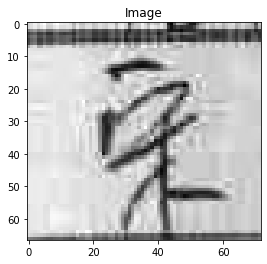

In [34]:
plt.title('Image')
plt.imshow(Image.open(img_list[0][0]),cmap='gray')

In [35]:
total_img = []
total_label = []
for file,label in img_list:
    img  = Image.open(file).convert('L').resize((50,50),Image.BILINEAR)
    total_label.append(label)
    total_img.append(np.array(img).reshape(-1))
total_img = np.array(total_img)
total_label = np.array(total_label)
print("Total label shape:",total_label.shape)
print("Total image shape:",total_img.shape)

Total label shape: (4469,)
Total image shape: (4469, 2500)


# Split train and test set

In [36]:
X_train,X_test,Y_train,Y_test = train_test_split(total_img,total_label,test_size=0.2,random_state=0)
X_train_scale = preprocessing.normalize(X_train)
X_test_scale = preprocessing.normalize(X_test)

# PCA explain ratio

Text(0, 0.5, 'cumulative explained variance')

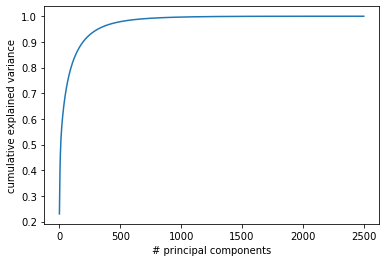

In [6]:
# 多少components 就可以代表0.95的資料
n_compons_rate = 0.95
pca = PCA()
pca.fit(X_train)
cum_explained_var_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cum_explained_var_ratio)
plt.xlabel('# principal components')
plt.ylabel('cumulative explained variance')

dim reduction one image

principle components shape: (2304, 2500)


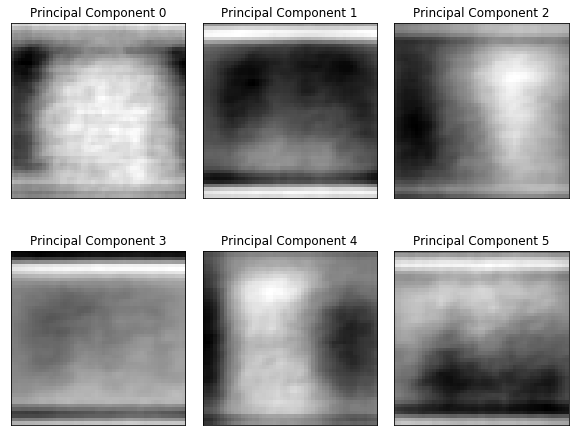

In [66]:
from sklearn.preprocessing import minmax_scale
pca = PCA(random_state=0)
trans_img = pca.fit_transform(X_train_scale)

scaled_comps = minmax_scale(pca.components_,axis=1)
print("principle components shape:",pca.components_.shape)
fig,axes = plt.subplots(2,3,figsize=(10,8),
                        subplot_kw = {"xticks":[],'yticks':[]},
                        gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    c = scaled_comps[i]
    ax.set_title('Principal Component '+str(i))
    ax.imshow(c.reshape(50,50),cmap='gray')


# predict function

In [7]:
def predict_accuracy(y, y_hat):
    return sum(y == y_hat) / y.shape[0]

# PCA components數 影響 SVM accuracy

In [68]:
def differ_components_SVM(X_train,Y_train,X_test,Y_test,):
    best_acc = 0
    best_rate = 100
    for i in range(90,0,-10):
        pca = PCA(i/100,random_state=random_state)
        pca.fit(X_train)
        transformed_images = pca.transform(X_train)
    #     print("transformed_images.shape:",transformed_images.shape)
        transform_test = pca.transform(X_test)
        clf = svm.SVC()
        clf.fit(transformed_images,Y_train)
        res = clf.predict(transform_test)
        acc = predict_accuracy(res,Y_test)
        if best_acc<acc:
            best_acc = acc
            best_rate = i/100
        
        print("{} components accuracy:{:.2%}".format(pca.components_.shape[0],acc))
    print("Best accuracy:{:.2%} , Best component rate:{}".format(best_acc,best_rate))


In [69]:
differ_components_SVM(X_train_scale,Y_train,X_test_scale,Y_test)

192 components accuracy:28.77%
96 components accuracy:29.29%
50 components accuracy:30.16%
25 components accuracy:29.12%
12 components accuracy:21.32%
6 components accuracy:14.04%
3 components accuracy:7.63%
1 components accuracy:3.81%
1 components accuracy:3.81%
Best accuracy:30.16% , Best component rate:0.7


## PCA  

In [16]:
pca = PCA(0.8,random_state=random_state)
# pca.fit(X_train_scale)
pipe = make_pipeline(StandardScaler(),pca)
pipe.fit(X_train)
transformed_train = pipe.transform(X_train)
transformed_test = pipe.transform(X_test)

print('-----PCA dimension reduction----')
print("transformed train images.shape:",transformed_train.shape)
print("transformed test  images.shape:",transformed_test.shape)


-----PCA dimension reduction----
transformed train images.shape: (3575, 96)
transformed test  images.shape: (894, 96)


## PCA reconstruct Image with different   component(standard scaler)

components_number: 306
components_number: 133
components_number: 71
components_number: 39
components_number: 19
components_number: 9
components_number: 5
components_number: 2
components_number: 1
components_number: 1


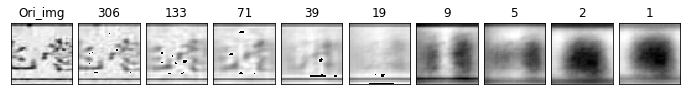

In [71]:
def diff_compon_reconstruct(X_train,X_test,k):
    diff_reconstruct=[]
    diff_reconstruct.append((Image.fromarray(X_train[k].reshape(50,50) ,'L'),"Ori_img"))

    for i in range(95,0,-10):
        pca = PCA(i/100,random_state=0)
        pipe = make_pipeline(StandardScaler(),pca)
        pca.fit(X_train)
        transformed_train = pca.transform(X_train)
        reconstruct_image = pca.inverse_transform(transformed_train)
        reconstruct_image = reconstruct_image.reshape((reconstruct_image.shape[0],50,50)).astype(np.uint8)
        img_pca = Image.fromarray(reconstruct_image[k],'L')
        print("components_number:",pca.components_.shape[0])
        diff_reconstruct.append((img_pca,pca.components_.shape[0]))
    fig, axes = plt.subplots(1,10, figsize=(12, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        img_pca = diff_reconstruct[i][0]
        ax.set_title(diff_reconstruct[i][1])
        ax.imshow(img_pca,cmap='gray')
       
   
diff_compon_reconstruct(X_train,X_test,k=10)

## PCA reconstruct Image with different   component

In [74]:
def diff_component_reconstruct(X_train_scale,X_test_scale,X_train,k):
    diff_reconstruct=[]
    diff_reconstruct.append((Image.fromarray(X_train[k].reshape(50,50) ,'L'),"Ori_img"))

    for i in range(95,0,-10):
        pca = PCA(i/100,random_state=0)
        pipe = make_pipeline(StandardScaler(),pca)
        pca.fit(X_train_scale)
        transformed_train = pca.transform(X_train_scale)
        reconstruct_image = pca.inverse_transform(transformed_train)
        reconstruct_image = reconstruct_image.reshape((reconstruct_image.shape[0],50,50)).astype(np.uint8)
        img_pca = Image.fromarray(reconstruct_image[k],'L')
        print("components_number:",pca.components_.shape[0])
        diff_reconstruct.append((img_pca,pca.components_.shape[0]))
    fig, axes = plt.subplots(1,10, figsize=(12, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        img_pca = diff_reconstruct[i][0]
        ax.set_title(diff_reconstruct[i][1])
        ax.imshow(img_pca,cmap='gray')
       
   
diff_component_reconstruct(X_train_scale,X_test_scale,X_train,k=10)

components_number: 308


KeyboardInterrupt: 

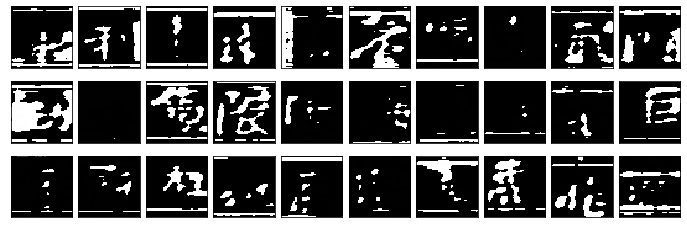

In [9]:
fig, axes = plt.subplots(3,10, figsize=(12, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

reconstruct_image = pca.inverse_transform(transformed_train)
reconstruct_image = reconstruct_image.reshape((reconstruct_image.shape[0],50,50)).astype(np.uint8)
for i, ax in enumerate(axes.flat):
        img_pca = Image.fromarray(reconstruct_image[i] ,'L')
        ax.imshow(img_pca,cmap='gray')

# LDA

In [10]:
def LDA(X_train,Y_train,X_test,Y_test):
    lda = LinearDiscriminantAnalysis(solver='svd')
    pipe = make_pipeline(StandardScaler(),lda)
    lda.fit(X_train,Y_train)
    transform_images = lda.transform(X_train)
    transform_test = lda.transform(X_test)
    return transform_images,transform_test
lda_train,lda_test = LDA(X_train,Y_train,X_test,Y_test)

## KPCA

In [11]:
from sklearn.decomposition import KernelPCA
def KPCA(X_train,Y_train,X_test,Y_test):
    kpca = KernelPCA(n_components=232,kernel='rbf')
    pipe = make_pipeline(StandardScaler(),kpca)
    pipe.fit(X_train)
    transform_images = pipe.transform(X_train)
    transform_test = pipe.transform(X_test)
    return transform_images,transform_test
kpca_train,kpca_test = KPCA(X_train,Y_train,X_test,Y_test)

# SVM 

In [13]:


print('-----PCA dimension reduction----')
print("transformed train images.shape:",transformed_train.shape)
print("transformed test  images.shape:",transformed_test.shape)
def SVM(X_train,Y_train,X_test,Y_test):
    clf = svm.SVC(kernel='rbf',random_state=random_state)
    clf.fit(X_train,Y_train)
    res = clf.predict(X_test)
    return predict_accuracy(res,Y_test)
# print("PCA+SVM:{:.2%}".format(SVM(transformed_train,Y_train,transformed_test,Y_test))) 
print("KPCA+SVM:{:.2%}".format(SVM(kpca_train,Y_train,kpca_test,Y_test))) 
print("LDA+SVM:{:.2%}".format(SVM(lda_train,Y_train,lda_test,Y_test)))

-----PCA dimension reduction----
transformed train images.shape: (3575, 96)
transformed test  images.shape: (3575, 96)
KPCA+SVM:26.51%
LDA+SVM:2.57%


## KNN

In [25]:
from sklearn.neighbors import KNeighborsClassifier

def KNN(X_train,Y_train,X_test,Y_test,k):
    knn =  KNeighborsClassifier(n_neighbors=k,weights = 'distance')
    knn.fit(X_train,Y_train)
    res = knn.predict(X_test)
    return predict_accuracy(res,Y_test)
n_neighbor = 1
print("PCA+KNN:{:.2%}".format(KNN(transformed_train,Y_train,transformed_test,Y_test,n_neighbor))) 
print("KPCA+KNN:{:.2%}".format(KNN(kpca_train,Y_train,kpca_test,Y_test,n_neighbor))) 
print("LDA+KNN:{:.2%}".format(KNN(lda_train,Y_train,lda_test,Y_test,n_neighbor)))

PCA+KNN:19.35%
KPCA+KNN:24.72%
LDA+KNN:3.36%


# Perceptron

In [97]:
from sklearn.linear_model import Perceptron
def perceptron(X_train,Y_train,X_test,Y_test):
    clf =Perceptron(tol=1e-5,random_state=random_state)
    clf.fit(X_train,Y_train)
    clf.score(X_train,Y_train)
    clf.score(X_test,Y_test)
    res = clf.score(X_test,Y_test)
    return res
print("PCA+Perceptron:{:.2%}".format(perceptron(transformed_train,Y_train,transformed_test,Y_test))) 
print("KPCA+Perceptron:{:.2%}".format(perceptron(kpca_train,Y_train,kpca_test,Y_test))) 
print("LDA+Perceptron:{:.2%}".format(perceptron(lda_train,Y_train,lda_test,Y_test)))

PCA+Perceptron:9.01%
KPCA+Perceptron:20.10%
LDA+Perceptron:1.21%


# MLP

In [101]:
def MLP(X_train,Y_train,X_test,Y_test,hidden_layer,max_iter ):
    clf = MLPClassifier(hidden_layer_sizes=hidden_layer,solver='adam',activation='relu',max_iter=max_iter,random_state=random_state)
    clf.fit(X_train,Y_train)
    res = clf.predict(X_test)
    return predict_accuracy(res,Y_test)
max_iter= 5000
hidden_size = (128,256)
print("PCA+MLP:{:.2%}".format(MLP(transformed_train,Y_train,transformed_test,Y_test,hidden_size,max_iter))) 
print("KPCA+MLP:{:.2%}".format(MLP(kpca_train,Y_train,kpca_test,Y_test,hidden_size,max_iter))) 
print("LDA+MLP:{:.2%}".format(MLP(lda_train,Y_train,lda_test,Y_test,hidden_size,max_iter)))

PCA+MLP:30.68%
KPCA+MLP:29.98%
LDA+MLP:2.43%


In [19]:
max_iter = 5000
print("MLP with different components")
for i in range(90,40,-10):
    pca = PCA(i/100,random_state=random_state)
    pipe = make_pipeline(StandardScaler(),pca)
    transform_images = pipe.fit_transform(X_train)
    transform_test = pipe.transform(X_test)
    clf = MLPClassifier(max_iter=max_iter,random_state=random_state)
    clf.fit(transform_images,Y_train)
    res = clf.predict(transform_test)
    acc = predict_accuracy(res,Y_test)
    print("{} components accuracy:{:.2%}".format(pca.components_.shape[0],acc))

MLP with different components
196 components accuracy:18.23%
96 components accuracy:20.36%
49 components accuracy:24.27%
23 components accuracy:21.92%
11 components accuracy:15.77%


## Naive Bayes

In [42]:
from sklearn.naive_bayes import *
Categorical_NB = CategoricalNB()
pipe = make_pipeline(MinMaxScaler(),Categorical_NB)
pipe.fit(X_train_scale, Y_train)
res = pipe.predict(X_test_scale)
predict_accuracy(res,Y_test)

IndexError: index 1 is out of bounds for axis 1 with size 1

In [39]:
from sklearn.preprocessing import MinMaxScaler
Complement_NB = ComplementNB()
pipe = make_pipeline(MinMaxScaler(),Complement_NB)
pipe.fit(X_train, Y_train)
res = pipe.predict(X_test)
predict_accuracy(res,Y_test)

0.15324384787472037

In [40]:
Gaussian_NB = GaussianNB()
pipe = make_pipeline(MinMaxScaler(),Gaussian_NB)
pipe.fit(X_train, Y_train)
res = pipe.predict(X_test)
predict_accuracy(res,Y_test)

0.12863534675615212

In [41]:
Multinomial_NB = MultinomialNB()
pipe = make_pipeline(MinMaxScaler(),Multinomial_NB)
pipe.fit(X_train, Y_train)
res = pipe.predict(X_test)
predict_accuracy(res,Y_test)

0.20693512304250558